## Importing all libraries

In [75]:
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as TF
import torch.nn as nn
import torch.nn.functional as F

## HYPERPARAMS

In [76]:
BATCH_SIZE = 10
device = torch.device('cuda')

## Loading Data

Copying 4-5 images of each pokemon into a train_data folder for 500 pokemons.

In [44]:
import shutil
!mkdir train_data

folders = torch.randint(1,700,(500,1))
for _,i in enumerate(folders):
    for j in range(1,6):
        path = f'./pokemon/{i.item()}/{i.item()}-{j}.png'
        if os.path.isfile(path):
            shutil.copy(path, './train_data')

In [45]:
print(len(os.listdir('./train_data')))

1835


Creating dataset and dataloader

In [270]:
class pokemonDataset():

    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_paths = sorted(list(self.img_dir + '/' + filename for filename in sorted(os.listdir(self.img_dir))))
        self.transform = TF.Compose([TF.Resize((64,64)), TF.ToTensor()])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        path = self.img_paths[index]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)

        # normalising pixel values between -1 to 1
        i = 255/2
        img = (img - i)/i
        return img

In [271]:
data  = pokemonDataset('./train_data')
print(len(data))
realImagesDataLoader = DataLoader(data, BATCH_SIZE, shuffle=True)

1835


Creating function to show the images

In [274]:
def show_batch(image_batch, title):
    plt.figure(figsize=(17,17))
    # denormalizing pixel values between 0 - 255
    i = 255/2
    image_batch = image_batch*i + i
    # print(image_batch.shape)
    grid = torchvision.utils.make_grid(image_batch, nrow=10)
    # print(grid.shape)
    plt.imshow(grid.cpu().detach().numpy().transpose(1,2,0))
    plt.title(title)
    plt.show()

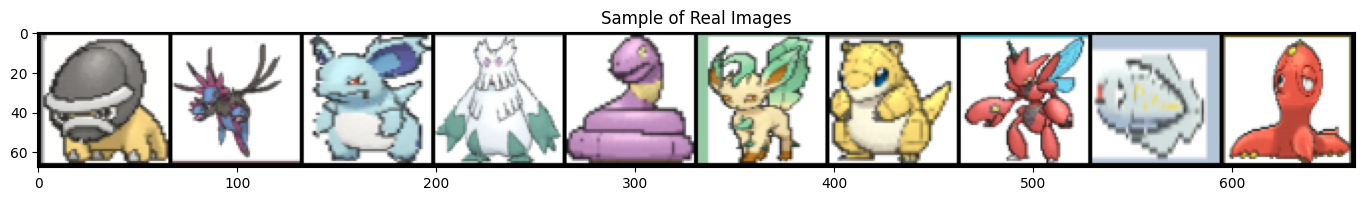

In [275]:
for i in realImagesDataLoader:
    show_batch(i,'Sample of Real Images')
    break

## Defining the GAN

Defining Repetitive classes

In [276]:
class ConvLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, alpha, kernel_size=2, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=alpha, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class ConvReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

Defining the Discriminator

In [277]:
class Discriminator(nn.Module):
    
    def __init__(self, alpha):
        super().__init__()

        # input: n_samples x 3 x 64 x 64
        self.conv1 = ConvLeakyReLU(3, 128, alpha)
        self.conv2 = ConvLeakyReLU(128, 256, alpha)
        self.conv3 = ConvLeakyReLU(256,512,alpha)
        self.conv4 = ConvLeakyReLU(512,1024,alpha)
        
        # size : n_samples x 1024 x 4 x 4
        # self.final_conv = nn.Sequential(
        #     nn.Conv2d(1024, 1, 2, 2, padding=0, bias=False),
        #     nn.Conv2d(1,1, 2, 2, padding=0, bias=False),
        #     nn.BatchNorm2d(1),
        #     nn.Sigmoid()
        # )

        self.final_conv = nn.Sequential(
            nn.Conv2d(1024,1,2,2),
            nn.Flatten(),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.final_conv(x)
        return x

In [278]:
x = torch.randn((1,3,64,64))
model = Discriminator(0.5)
model(x).shape

torch.Size([1, 1])

Defining the Generator

In [279]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # input: n_samples x 1 x 100
        # self.linear1 = nn.Sequential(
        #     nn.Linear(100,1024*4*4, bias=False),
        #     nn.BatchNorm2d(1024*4*4),
        #     nn.ReLU(inplace=True))
        # shape : n_samples x 1024*4*4 can be reshaped into n_samples x 1024 x 4 x 4

        # transforming input via transpose conv
        # 3 input of size n_samples x 1 x 1 x1024
        self.conv0 = nn.Sequential(
            nn.ConvTranspose2d(1, 1, 4, 4, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )
        # shape = n_samples x 1 x 4 x 1024*4
        # can be reshaped as n_samples x 1024 x 4 x 4
        self.conv1 = ConvReLU(1024, 512, 2, 2)
        self.conv2 = ConvReLU(512, 256, 2, 2)
        self.conv3 = ConvReLU(256, 128, 2, 2)
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 2, 2, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv0(x)
        x = x.reshape((-1,1024, 4, 4))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x


In [280]:
x = torch.randn((1,1,1,1024))
model = Generator()
model(x).shape

torch.Size([1, 3, 64, 64])